# Altitude Analysis

In [109]:
import pandas as pd
import scipy.stats as stats
from simpledbf import Dbf5 as db
import matplotlib.pyplot as plt

## Reading dbf 

In [110]:
dbf = db("ZonalSt_alt_municip.dbf")
df_altitudes = dbf.to_dataframe()
df_altitudes.head()

,NM_MUN,ZONE_CODE,COUNT,AREA,MIN,MAX,RANGE,MEAN,STD,SUM,VARIETY,MAJORITY,MINORITY,MEDIAN
0,Abadia dos Dourados,1,1092,0.075833,639,988,349,772.872711,61.986597,843977.0,270,760,639,774
1,Abaeté,2,2245,0.155903,564,904,340,642.046771,43.834646,1441395.0,223,632,717,637
2,Abre Campo,3,581,0.040347,391,1068,677,672.084337,126.220764,390481.0,345,642,391,669
3,Acaiaca,4,123,0.008542,450,744,294,609.121951,60.718005,74922.0,96,606,450,617
4,Açucena,5,1007,0.069931,197,964,767,502.974181,201.501221,506495.0,515,243,197,492


## Using Pearson Correlation

In [111]:
print("CORRELATION BETWEEN MEAN MUNICIPAL ALTITUDE AND MUNICIPAL ALTITUDE RANGE")
corr,pval=stats.pearsonr(df_altitudes['MEAN'],df_altitudes['RANGE'])
print("Correlation:",corr)
print("P_VALUE:",pval)

CORRELATION BETWEEN MEAN MUNICIPAL ALTITUDE AND MUNICIPAL ALTITUDE RANGE
Correlation: 0.20147585986959732
P_VALUE: 2.908345116215118e-09


## Creating intervals of altitudes using pd.cut

In [112]:
df_altitudes = df_altitudes.sort_values(by="MEAN")
df_altitudes["Altitude"] = pd.cut(x=df_altitudes["MEAN"],bins=[0, 300, 600, 850, 1100, 1600]
                    ,labels=["0-300m","300-600m","600-850m","850-1100m","1100-1600m"])
df_altitudes[["NM_MUN","MEAN","Altitude"]]

,NM_MUN,MEAN,Altitude
783,Serra dos Aimorés,195.273764,0-300m
597,Pirapetinga,201.526749,0-300m
662,Salto da Divisa,217.307828,0-300m
18,Alpercata,219.131068,0-300m
815,Tumiritinga,230.138710,0-300m
...,...,...,...
771,Senador Amaral,1464.656250,1100-1600m
233,Delfim Moreira,1483.495202,1100-1600m
12,Alagoa,1507.425000,1100-1600m
465,Marmelópolis,1543.764706,1100-1600m


## Finding the number of cities in each altitude interval

In [113]:
labels=["0-300m","300-600m","600-850m","850-1100m","1100-1600m"]
number_of_cities = pd.Series({i:df_altitudes[df_altitudes["Altitude"]==i]["MEAN"].size for i in labels})
print(number_of_cities)

0-300m         28
300-600m      183
600-850m      324
850-1100m     268
1100-1600m     50
dtype: int64


## Creating population Dataframe from xls

In [114]:
df_pop = pd.read_excel("population.xls", sheet_name="Municípios")
df_pop = df_pop.dropna()
df_pop = df_pop[df_pop["UF"] == "MG"]
df_pop.head()

,UF,COD. UF,COD. MUNIC,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA
2244,MG,31.0,104.0,Abadia dos Dourados,7015.0
2245,MG,31.0,203.0,Abaeté,23535.0
2246,MG,31.0,302.0,Abre Campo,13719.0
2247,MG,31.0,401.0,Acaiaca,4056.0
2248,MG,31.0,500.0,Açucena,10140.0


## Correcting wrong names

In [115]:
wrong_names = df_altitudes[~df_altitudes['NM_MUN'].
    isin(df_pop['NOME DO MUNICÍPIO'])]["NM_MUN"].to_numpy()
correct_names = ["Pingo-d'Água","Dona Eusébia","São Sebastião da Vargem Alegre","Passa-Vinte",
                 "São Thomé das Letras","Brasópolis"]
for i in range(len(correct_names)):
    df_altitudes.at[df_altitudes[df_altitudes["NM_MUN"]==wrong_names[i]].index[0],
          "NM_MUN"] = correct_names[i]
df_altitudes = df_altitudes.rename(columns={"NM_MUN": "NOME DO MUNICÍPIO"})    

## Merging DFs

In [116]:
df_altitudes = df_altitudes.merge(df_pop)
df_altitudes[["NOME DO MUNICÍPIO","MEAN","Altitude","POPULAÇÃO ESTIMADA"]].head()

,NOME DO MUNICÍPIO,MEAN,Altitude,POPULAÇÃO ESTIMADA
0,Serra dos Aimorés,195.273764,0-300m,8767.0
1,Pirapetinga,201.526749,0-300m,10818.0
2,Salto da Divisa,217.307828,0-300m,7107.0
3,Alpercata,219.131068,0-300m,7478.0
4,Tumiritinga,230.138710,0-300m,6669.0


In [117]:
df_altitudes = df_altitudes.set_index(["Altitude","NOME DO MUNICÍPIO"])
df_altitudes[["MEAN","POPULAÇÃO ESTIMADA"]]

MEAN  POPULAÇÃO ESTIMADA
Altitude   NOME DO MUNICÍPIO                                 
0-300m     Serra dos Aimorés   195.273764              8767.0
           Pirapetinga         201.526749             10818.0
           Salto da Divisa     217.307828              7107.0
           Alpercata           219.131068              7478.0
           Tumiritinga         230.138710              6669.0
...                                   ...                 ...
1100-1600m Senador Amaral     1464.656250              5419.0
           Delfim Moreira     1483.495202              8201.0
           Alagoa             1507.425000              2760.0
           Marmelópolis       1543.764706              2938.0
           Itamonte           1570.446886             15136.0

[853 rows x 2 columns]

In [120]:
bins=[300, 600, 850, 1100, 1600]
pop = pd.Series({labels[i]:df_altitudes[df_altitudes["MEAN"] < bins[i]]["POPULAÇÃO ESTIMADA"].sum() for i in range(len(labels))})
print("POPULATION PER INTERVAL OF MEAN ALTITUDE")
print(pop)
pop_total = df_altitudes["POPULAÇÃO ESTIMADA"].sum()
pop_intervals = pd.Series({i:((df_altitudes.xs(i)["POPULAÇÃO ESTIMADA"].sum())/pop_total)*100 for i in labels})
print("PERCENT OF POPULATION PER INTERVAL OF MEAN ALTITUDE")
print(pop_intervals)

POPULATION PER INTERVAL OF MEAN ALTITUDE
0-300m          534873.0
300-600m       3546931.0
600-850m      11557929.0
850-1100m     20084287.0
1100-1600m    20869101.0
dtype: float64
PERCENT OF POPULATION PER INTERVAL OF MEAN ALTITUDE
0-300m         2.562990
300-600m      14.433099
600-850m      38.386886
850-1100m     40.856374
1100-1600m     3.760651
dtype: float64


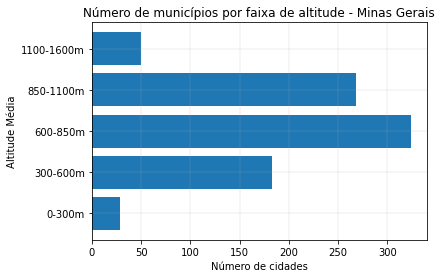

In [121]:
plt.barh(labels,number_of_cities)
plt.title("Número de municípios por faixa de altitude - Minas Gerais")
plt.xlabel('Número de cidades')
plt.ylabel('Altitude Média')
plt.grid(lw="0.2")
plt.show()

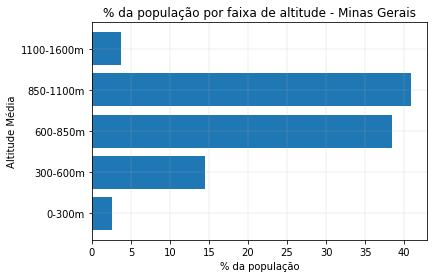

In [122]:
plt.barh(labels,pop_intervals)
plt.title("% da população por faixa de altitude - Minas Gerais")
plt.xlabel('% da população')
plt.ylabel('Altitude Média')
plt.grid(lw="0.2")
plt.show()

In [123]:
df_altitudes = df_altitudes.loc[:,['MEAN','MIN','MAX','RANGE','AREA','POPULAÇÃO ESTIMADA']]
df_altitudes.to_csv('municipal_altitude.csv')